In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 100
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":0.01*numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.uniform(low=-10, high=10, size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_90,noise_91,noise_92,noise_93,noise_94,noise_95,noise_96,noise_97,noise_98,noise_99
0,-12.874163,level_449,level_277,level_280,level_254,level_328,level_483,level_187,level_395,level_321,...,level_37,level_474,level_447,level_133,level_57,level_343,level_419,level_105,level_120,level_198
1,9.711458,level_371,level_39,level_224,level_312,level_23,level_312,level_417,level_280,level_397,...,level_221,level_261,level_489,level_75,level_220,level_200,level_147,level_39,level_415,level_220
2,38.334844,level_119,level_140,level_216,level_75,level_497,level_474,level_238,level_318,level_451,...,level_300,level_389,level_36,level_92,level_293,level_377,level_129,level_404,level_468,level_67
3,-13.515243,level_4,level_386,level_474,level_266,level_394,level_299,level_73,level_261,level_354,...,level_99,level_223,level_135,level_270,level_384,level_488,level_105,level_336,level_187,level_254
4,-24.187268,level_495,level_112,level_101,level_474,level_422,level_131,level_440,level_340,level_204,...,level_9,level_360,level_320,level_363,level_91,level_403,level_400,level_83,level_198,level_202


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-1.513048,-6.230579,-25.116287,-8.944501,-21.177307,-6.229544,-7.076944,7.184245,12.865531,9.753160,...,1.945685,9.549511,0.700312,-2.462173,3.003205,8.308536,-7.649715,0.674574,-9.931072,-6.686281
1,-5.092637,2.563950,-5.146714,18.060756,9.724620,3.321088,7.946129,3.003472,9.662754,-5.594368,...,12.883186,-1.142683,-5.785362,-3.688092,6.729931,6.353634,5.830431,5.029487,5.721812,3.256890
2,30.004566,-3.343791,20.641545,13.672156,3.700730,10.656596,3.446008,7.442591,7.639195,22.343703,...,12.959995,24.190993,-8.328230,17.488429,-1.672550,2.742253,3.524143,15.454277,-3.181155,12.509647
3,-2.981089,10.484498,-5.313327,-6.866242,3.141923,-4.461333,-8.702389,-0.471324,7.323932,-7.131799,...,-4.391710,14.118416,2.610363,-10.600073,-17.368391,-7.294639,0.185325,-10.882141,7.210492,0.312632
4,-1.297729,0.807132,6.627410,-13.469141,2.712969,-13.135133,-2.402777,-6.875850,-9.612552,-0.184537,...,2.636804,10.280721,-5.358570,-5.306694,-2.493206,-10.852978,-3.689701,0.270860,-5.114608,0.213857


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-1.009064,-4.647195,-20.147981,-4.425599,-14.365426,-5.694198,-5.187961,4.147548,5.100483,3.594300,...,1.370046,4.167809,0.475293,-2.089130,2.409710,4.168948,-4.751705,0.385555,-6.331918,-3.997658
1,-3.854546,2.417388,-4.775149,13.715804,4.720033,2.484697,7.277871,1.506406,5.726275,-2.491636,...,7.259130,-0.474531,-3.772216,-2.337371,5.906046,5.652308,3.637710,4.302692,4.420554,2.235388
2,22.147355,-1.101825,14.769390,8.559039,2.129624,6.176821,1.095324,3.984349,5.775304,14.710922,...,7.590208,13.216203,-2.419801,9.571055,-0.986354,0.890660,1.434199,1.284927,-1.256006,5.129814
3,-1.659237,5.565465,-4.006084,-4.868464,2.010691,-3.140763,-5.726121,-0.271394,4.142982,-6.445358,...,-3.385421,4.342753,1.934443,-8.464209,-6.950073,-6.021518,0.112980,-8.320901,3.341124,0.121133
4,-0.614772,0.322179,3.642476,-10.643384,1.731244,-9.712541,-1.603141,-4.946882,-7.463827,-0.101225,...,1.681475,3.007765,-2.761916,-1.433006,-1.009140,-1.844917,-1.780740,0.128663,-1.700460,0.078270


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-2.399478,0.000000,-26.211767,-3.361913,-12.135734,-3.182448,-2.125594,1.035232,30.664178,20.243749,...,3.025680,5.439614,-0.301097,1.556660,2.262499,3.975890e+00,-2.500526,1.924410,-3.614131,-0.153619
1,-2.587488,0.878128,-5.764871,14.133825,-0.239112,3.869451,9.446724,-0.497875,2.999449,-4.493225,...,16.857921,-1.398428,-18.479404,-4.046480,0.000000,3.759956e+00,7.166941,3.018042,2.996399,0.661720
2,8.318939,-7.790363,9.357811,7.156511,1.179795,2.603946,-0.660033,0.103150,4.797173,20.143169,...,5.431054,15.970501,-13.759157,9.152312,-1.983332,2.084270e-01,-4.752590,0.000000,-3.480913,3.291111
3,-3.867960,6.209430,-2.662721,-2.156680,6.959526,-0.926608,-4.442534,0.723637,7.643148,-4.379367,...,-3.065288,3.992761,2.088026,-7.646752,-6.692370,-3.860297e+00,3.268640,-7.768534,3.738161,1.313709
4,2.084048,5.119931,5.879238,-10.827490,-0.718424,-5.776497,5.628753,0.448616,-4.936796,6.463213,...,3.368940,13.979229,-0.813012,0.625445,-1.613039,1.110223e-16,-0.942434,3.493383,-0.175792,-0.031538


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.528258,0.499348,0.158013,0.167032,False
1,var_1_impact_code,0.497339,0.474269,0.127160,0.176702,False
2,var_2_impact_code,0.532780,0.508181,0.170097,0.171259,False
3,var_3_impact_code,0.549428,0.517778,0.178022,0.150785,False
4,var_4_impact_code,0.521878,0.491931,0.145970,0.191471,False
5,var_5_impact_code,0.529196,0.500085,0.141827,0.156528,False
6,var_6_impact_code,0.507799,0.479983,0.125375,0.139723,False
7,var_7_impact_code,0.523651,0.491273,0.135829,0.164575,False
8,var_8_impact_code,0.532169,0.507868,0.184174,0.188623,False
9,var_9_impact_code,0.531345,0.499113,0.158758,0.139789,False


(0.8415168464796285, 1.191578925974758e-30)


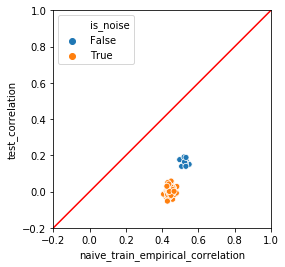

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8509121979497376, 5.722083469926415e-32)


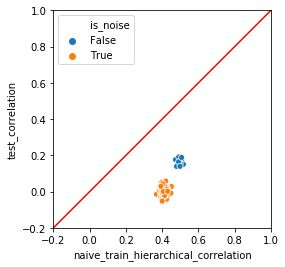

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8230446620455105, 2.7203921519573728e-28)


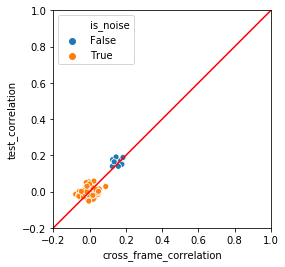

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
105,noise_95_impact_code,impact_code,True,True,-0.016923,0.396060,110.0,False
106,noise_96_impact_code,impact_code,True,True,-0.045459,0.022565,110.0,False
107,noise_97_impact_code,impact_code,True,True,0.048987,0.013974,110.0,False
108,noise_98_impact_code,impact_code,True,True,-0.000012,0.999518,110.0,False
109,noise_99_impact_code,impact_code,True,True,-0.014437,0.469076,110.0,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code',
 'noise_30_impact_code',
 'noise_46_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,-6.540678,-4.221338,2.939018,1.600485,2.530307
1,32.768202,-3.193801,-3.085955,0.029565,0.853627
2,-1.336840,-10.094927,-5.249408,-2.500638,-3.645002
3,1.100733,4.510366,2.112527,1.057285,1.028792
4,14.814182,7.881364,0.710606,0.348692,-0.051752


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

3.1962151945837904


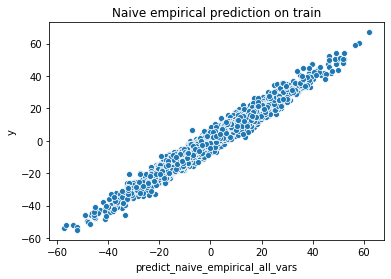

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

4.870150424693358


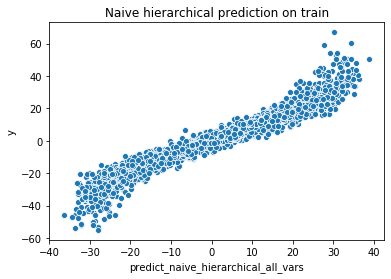

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

15.078974698420163


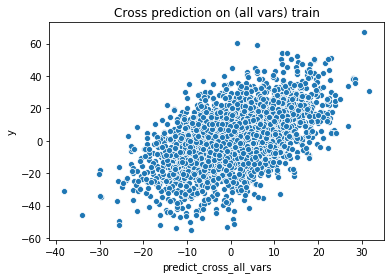

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

15.5824835044381


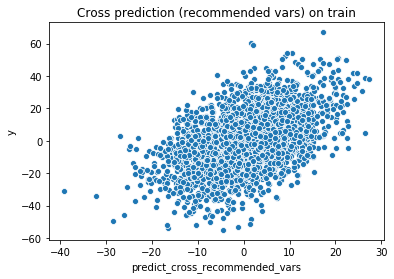

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

17.6570264829783


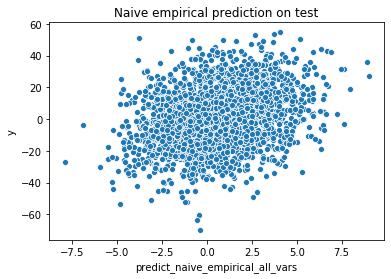

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

17.35695675325358


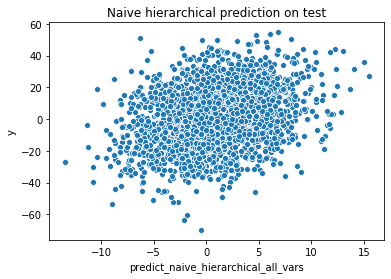

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

15.854087544043798


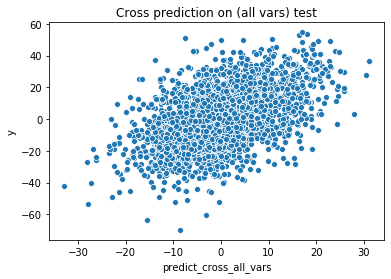

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

15.564409279822518


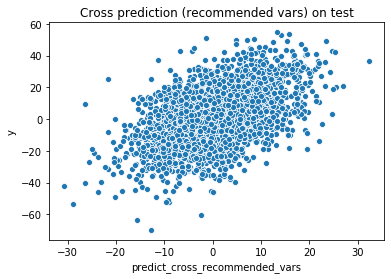

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     662.7
Date:                Fri, 26 Jul 2019   Prob (F-statistic):               0.00
Time:                        14:21:54   Log-Likelihood:                -6496.1
No. Observations:                2517   AIC:                         1.321e+04
Df Residuals:                    2406   BIC:                         1.386e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5401      0.065      8.289      0.000       0.412       0.668
var_0_impact_code        0.0572      0.008      6.933      0.000       0.041       0.073
var_1_impact_code        0.0544      0.009      6.336      0.000       0.038       0.071
var_2_impact_code        0.0561      0.008      6.809      0.000       0.040       0.072
var_3_impact_code        0.0708      0.008      8.821      0.000       0.055       0.087
var_4_impact_code        0.0671      0.008      8.088      0.000       0.051       0.083
var_5_impact_code        0.0644      0.008      7.834      0.000       0.048       0.080
var_6_impact_code        0.0653      0.008      7.725      0.000       0.049       0.082
var_7_impact_code        0.0597      0.008      7.167      0.000       0.043       0.076
var_8_impact_code        0.0614      0.008      7.469      0.000       0.045       0.078
var_9_impact_code        0.0583      0.008      7.076      0.000       0.042       0.074
noise_0_impact_code      0.0501      0.009      5.345      0.000       0.032       0.068
noise_1_impact_code      0.0452      0.009      4.874      0.000       0.027       0.063
noise_2_impact_code      0.0491      0.009      5.347      0.000       0.031       0.067
noise_3_impact_code      0.0347      0.009      3.875      0.000       0.017       0.052
noise_4_impact_code      0.0408      0.009      4.469      0.000       0.023       0.059
noise_5_impact_code      0.0392      0.009      4.319      0.000       0.021       0.057
noise_6_impact_code      0.0282      0.009      2.971      0.003       0.010       0.047
noise_7_impact_code      0.0442      0.009      4.671      0.000       0.026       0.063
noise_8_impact_code      0.0296      0.009      3.192      0.001       0.011       0.048
noise_9_impact_code      0.0520      0.009      5.634      0.000       0.034       0.070
noise_10_impact_code     0.0429      0.009      4.761      0.000       0.025       0.061
noise_11_impact_code     0.0364      0.010      3.759      0.000       0.017       0.055
noise_12_impact_code     0.0389      0.009      4.189      0.000       0.021       0.057
noise_13_impact_code     0.0278      0.010      2.847      0.004       0.009       0.047
noise_14_impact_code     0.0471      0.010      4.941      0.000       0.028       0.066
noise_15_impact_code     0.0276      0.010      2.770      0.006       0.008       0.047
noise_16_impact_code     0.0512      0.009      5.469      0.000       0.033       0.070
noise_17_impact_code     0.0461      0.009      4.974      0.000       0.028       0.064
noise_18_impact_code     0.0356      0.009      3.791      0.000       0.017       0.054
noise_19_impact_code     0.0435      0.009      4.643      0.000       0.025       0.062
noise_20_impact_code     0.0451      0.009      4.887    

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.9680482926441748

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.055843312488653596

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     8.884
Date:                Fri, 26 Jul 2019   Prob (F-statistic):          2.19e-112
Time:                        14:21:54   Log-Likelihood:                -10401.
No. Observations:                2517   AIC:                         2.102e+04
Df Residuals:                    2406   BIC:                         2.167e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.4115      0.312      1.319      0.187      -0.200       1.023
var_0_impact_code        0.4253      0.048      8.873      0.000       0.331       0.519
var_1_impact_code        0.3853      0.053      7.252      0.000       0.281       0.489
var_2_impact_code        0.4038      0.049      8.250      0.000       0.308       0.500
var_3_impact_code        0.4416      0.047      9.410      0.000       0.350       0.534
var_4_impact_code        0.4502      0.052      8.720      0.000       0.349       0.551
var_5_impact_code        0.3831      0.049      7.825      0.000       0.287       0.479
var_6_impact_code        0.3756      0.051      7.303      0.000       0.275       0.476
var_7_impact_code        0.3460      0.049      7.088      0.000       0.250       0.442
var_8_impact_code        0.4591      0.046      9.901      0.000       0.368       0.550
var_9_impact_code        0.4053      0.047      8.665      0.000       0.314       0.497
noise_0_impact_code     -0.0270      0.064     -0.424      0.671      -0.152       0.098
noise_1_impact_code      0.0230      0.058      0.393      0.694      -0.092       0.138
noise_2_impact_code      0.0254      0.057      0.445      0.656      -0.086       0.137
noise_3_impact_code      0.0297      0.057      0.519      0.604      -0.083       0.142
noise_4_impact_code      0.1118      0.056      1.983      0.048       0.001       0.222
noise_5_impact_code      0.1000      0.057      1.745      0.081      -0.012       0.212
noise_6_impact_code     -0.0691      0.059     -1.178      0.239      -0.184       0.046
noise_7_impact_code      0.0333      0.059      0.568      0.570      -0.082       0.148
noise_8_impact_code      0.0265      0.059      0.452      0.651      -0.088       0.141
noise_9_impact_code      0.0844      0.058      1.456      0.146      -0.029       0.198
noise_10_impact_code     0.0979      0.057      1.715      0.086      -0.014       0.210
noise_11_impact_code    -0.1243      0.065     -1.920      0.055      -0.251       0.003
noise_12_impact_code    -0.0325      0.058     -0.563      0.573      -0.146       0.081
noise_13_impact_code    -0.0775      0.063     -1.223      0.222      -0.202       0.047
noise_14_impact_code    -0.0374      0.061     -0.610      0.542      -0.158       0.083
noise_15_impact_code    -0.2191      0.065     -3.378      0.001      -0.346      -0.092
noise_16_impact_code    -0.0051      0.061     -0.083      0.934      -0.125       0.115
noise_17_impact_code     0.0919      0.059      1.545      0.122      -0.025       0.209
noise_18_impact_code    -0.0559      0.061     -0.915      0.360      -0.176       0.064
noise_19_impact_code    -0.0328      0.056     -0.589      0.556      -0.142       0.076
noise_20_impact_code     0.0325      0.060      0.545    

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.2888427018421177

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.23881286287035353

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     66.10
Date:                Fri, 26 Jul 2019   Prob (F-statistic):          5.08e-140
Time:                        14:21:55   Log-Likelihood:                -10484.
No. Observations:                2517   AIC:                         2.099e+04
Df Residuals:                    2504   BIC:                         2.107e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.4844      0.312      1.553      0.121      -0.127       1.096
var_0_impact_code        0.4393      0.047      9.282      0.000       0.347       0.532
var_1_impact_code        0.3839      0.053      7.283      0.000       0.281       0.487
var_2_impact_code        0.4350      0.049      8.945      0.000       0.340       0.530
var_3_impact_code        0.4382      0.046      9.433      0.000       0.347       0.529
var_4_impact_code        0.4642      0.052      9.012      0.000       0.363       0.565
var_5_impact_code        0.3765      0.049      7.719      0.000       0.281       0.472
var_6_impact_code        0.3910      0.051      7.664      0.000       0.291       0.491
var_7_impact_code        0.3637      0.048      7.564      0.000       0.269       0.458
var_8_impact_code        0.4649      0.046     10.091      0.000       0.375       0.555
var_9_impact_code        0.4144      0.046      8.916      0.000       0.323       0.506
noise_30_impact_code     0.2075      0.054      3.829      0.000       0.101       0.314
noise_46_impact_code     0.1986      0.060      3.336      0.001       0.082       0.315
==============================================================================
Omnibus:                        0.821   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.663   Jarque-Bera (JB):                0.747
Skew:                          -0.005   Prob(JB):                        0.688
Kurtosis:                       3.084   Cond. No.                         6.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.24055662490558594

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.2663748324640852